In [4715]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats


%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [4716]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [4717]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [4718]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total'].to_frame()

    upsampled = y_data.resample('MS')
    y_data = upsampled.interpolate(method='spline', order=3)

    return y_data


### Combine Y and X data

In [4719]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")
df1 = regressionData.iloc[0:355,:].copy()

df1.to_csv("tmp_df1.csv ")

### Save transformations of GDP

In [4720]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()


In [4721]:
df1.columns.tolist()

['gdp_total',
 '^AEX',
 'ASML.AS',
 'AIR',
 'ING',
 'WKL.AS',
 'STLA',
 'AD.AS',
 'PHG',
 '^FVX',
 '^TNX',
 '^TYX',
 'Bankruptcies',
 'BusinessOutlook_Industry',
 'BusinessOutlook_Retail',
 'Consumentenvertrouwen_1',
 'EconomischKlimaat_2',
 'Koopbereidheid_3',
 'EconomischeSituatieLaatste12Maanden_4',
 'EconomischeSituatieKomende12Maanden_5',
 'FinancieleSituatieLaatste12Maanden_6',
 'FinancieleSituatieKomende12Maanden_7',
 'GunstigeTijdVoorGroteAankopen_8',
 'CPI_1',
 'CPIAfgeleid_2',
 'MaandmutatieCPI_3',
 'MaandmutatieCPIAfgeleid_4',
 'ProducerConfidence_1',
 'ExpectedActivity_2',
 'Crude oil, average',
 'Crude oil, Brent',
 'Crude oil, Dubai',
 'Crude oil, WTI',
 'Coal, Australian',
 'Coal, South African **',
 'Natural gas, US',
 'Natural gas, Europe',
 'Liquefied natural gas, Japan',
 'Natural gas index',
 'Cocoa',
 'Coffee, Arabica',
 'Coffee, Robusta',
 'Tea, avg 3 auctions',
 'Tea, Colombo',
 'Tea, Kolkata',
 'Tea, Mombasa',
 'Coconut oil',
 'Groundnuts',
 'Fish meal',
 'Groun

In [4722]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          'ASML.AS',
          'AIR',
          'ING',
          'WKL.AS',
          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'CPIAfgeleid_2',
          'ProducerConfidence_1', 
          'Crude oil, Brent',
          'Gold', 
          'M3_1', 
          'M3_2',
          'CCICP_NLD_CLI', 
          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
          'Natural gas, Europe', 
          'CCICP_DEU', 
          'United States_unemply_F',
          'United States_unemply_M', 
        ]]


### Drop if number of observations less than GDP

In [4723]:

def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)

['ASML.AS']


### Add 'sure' data and random data

In [4724]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

### Standard Scaler

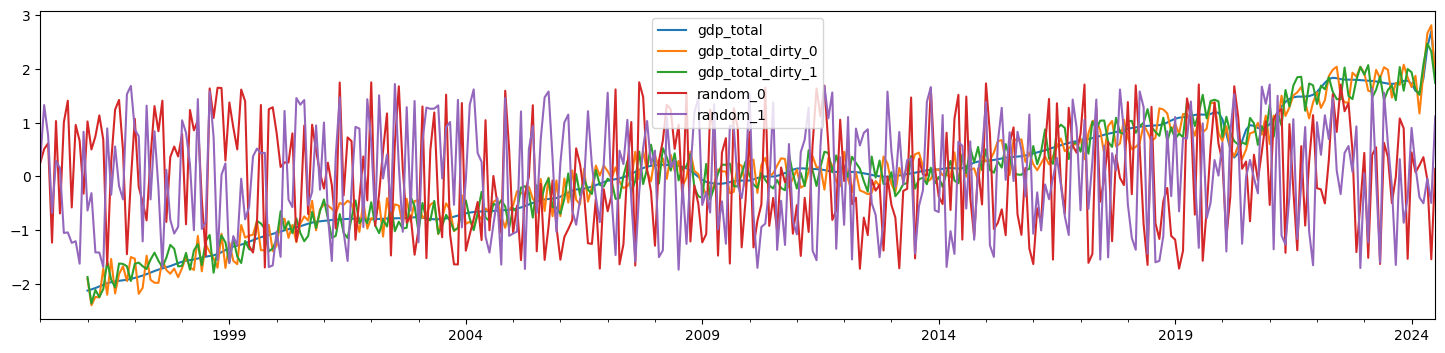

In [4725]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [4726]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [4727]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:300,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [4728]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
AIR,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
ING,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
WKL.AS,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Bankruptcies,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Koopbereidheid_3,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
EconomischeSituatieLaatste12Maanden_4,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality


In [4729]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
AIR,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
ING,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
WKL.AS,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
EconomischeSituatieLaatste12Maanden_4,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality


In [4730]:
#scaled_features_df[['Netherlands_unemply_F', 'United States_unemply_M', 'gdp_total']].plot()

In [4731]:
scaled_features_df.head(20)

,gdp_total,^AEX,AIR,ING,WKL.AS,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,EconomischeSituatieLaatste12Maanden_4,...,Netherlands_unemply_F,Netherlands_unemply_M,"Natural gas, Europe",CCICP_DEU,United States_unemply_F,United States_unemply_M,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1
1995-01-01,NaN,-1.777491,-1.197497,-1.448858,NaN,-0.197557,0.283872,0.403553,0.094743,0.320913,...,2.294188,1.032212,-0.688984,-0.071206,0.207821,0.433027,NaN,NaN,0.253801,0.277060
1995-02-01,NaN,-1.779647,-1.192196,-1.435079,NaN,-0.453562,0.550353,0.661836,0.271144,0.567453,...,2.600233,1.227644,-0.688984,-0.118037,0.034229,0.234800,NaN,NaN,0.510532,1.327262
1995-03-01,NaN,-1.825242,-1.214213,-1.420651,-0.704674,0.016480,0.728007,0.862723,0.447544,0.769168,...,2.651241,1.292788,-0.690267,-0.036155,-0.023635,0.086131,NaN,NaN,0.616448,0.766779
1995-04-01,NaN,-1.797409,-1.202295,-1.380047,-0.699140,-0.348642,0.683594,0.719232,0.506344,0.701929,...,2.345196,1.032212,-0.682569,0.048682,0.034229,-0.012982,NaN,NaN,-1.230267,-0.676893
1995-05-01,NaN,-1.737717,-1.173005,-1.335939,-0.689261,-0.495530,0.728007,0.776629,0.565145,0.746755,...,2.447211,0.836780,-0.682569,0.101385,-0.081499,-0.062539,NaN,NaN,1.030242,0.289681
1995-06-01,NaN,-1.715368,-1.107006,-1.312702,-0.674553,-0.445168,0.594767,0.604440,0.506344,0.634691,...,2.396203,1.032212,-0.680002,0.135942,0.381413,-0.112096,NaN,NaN,-0.687757,0.157692
1995-07-01,NaN,-1.659131,-1.045566,-1.283319,-0.670272,-0.357035,0.639180,0.575742,0.623945,0.657104,...,1.886128,0.706492,-0.671021,0.119336,0.497141,-0.112096,NaN,NaN,1.008953,-1.050501
1995-08-01,NaN,-1.637697,-1.065045,-1.291256,-0.667130,-0.231131,0.816835,0.747931,0.741545,0.769168,...,2.141166,0.576204,-0.671021,0.023654,0.323549,-0.211209,NaN,NaN,1.408501,-1.039482
1995-09-01,NaN,-1.616840,-1.022364,-1.221246,-0.659364,-0.214344,0.816835,0.719232,0.800346,0.724342,...,2.498218,0.771636,-0.673587,-0.085904,0.207821,-0.310322,NaN,NaN,-0.576071,-1.234182
1995-10-01,NaN,-1.649092,-1.028823,-1.246073,-0.662840,-0.138802,0.950075,0.920120,0.859146,0.858819,...,2.600233,0.771636,-0.677436,-0.228118,0.034229,-0.409435,NaN,NaN,0.958355,-1.203966


In [4732]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
# Causing loss of data!!!
#scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    print(i)
    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

United States_unemply_F
United States_unemply_M


[13 18 27 28]
['CPI_1', 'M3_1', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


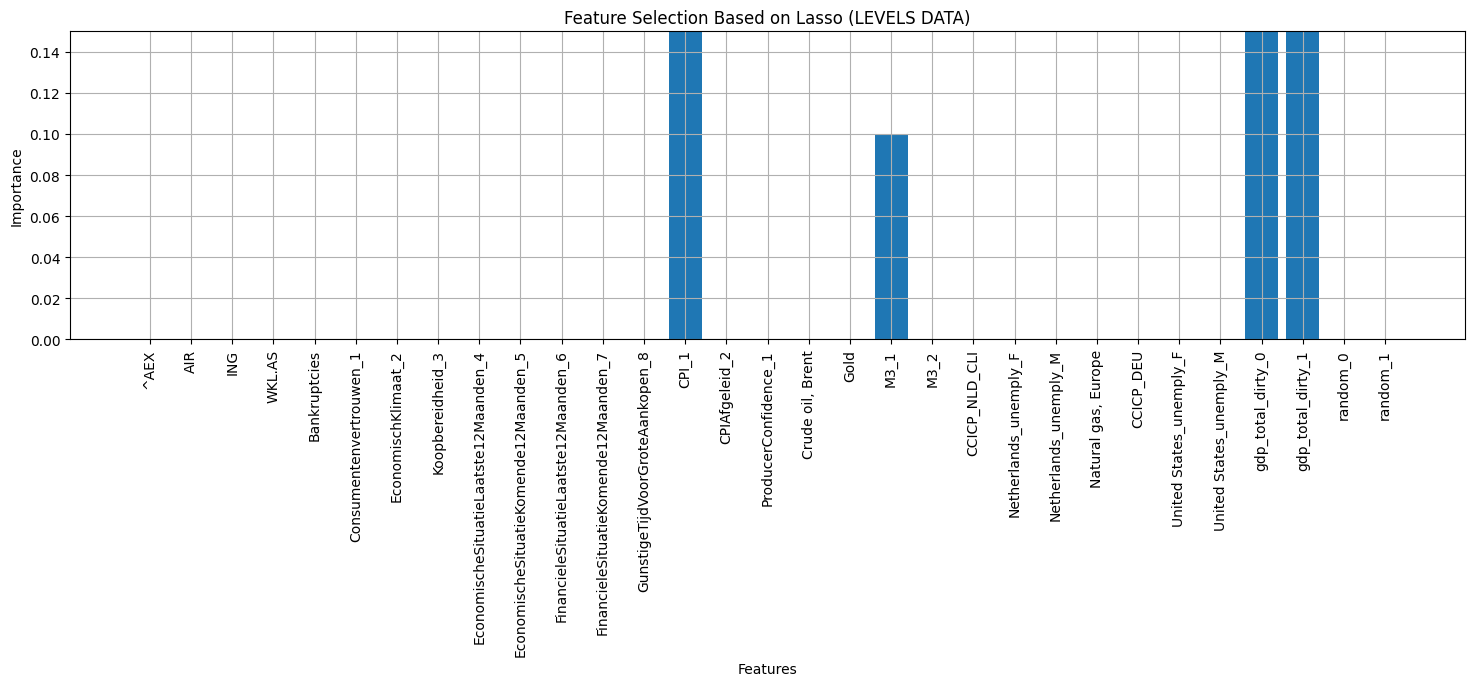

(355, 32)


In [4733]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
['^AEX', 'AIR', 'ING', 'WKL.AS', 'Bankruptcies', 'Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'CPIAfgeleid_2', 'ProducerConfidence_1', 'Crude oil, Brent', 'Gold', 'M3_1', 'M3_2', 'CCICP_NLD_CLI', 'Netherlands_unemply_F', 'Netherlands_unemply_M', 'Natural gas, Europe', 'CCICP_DEU', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


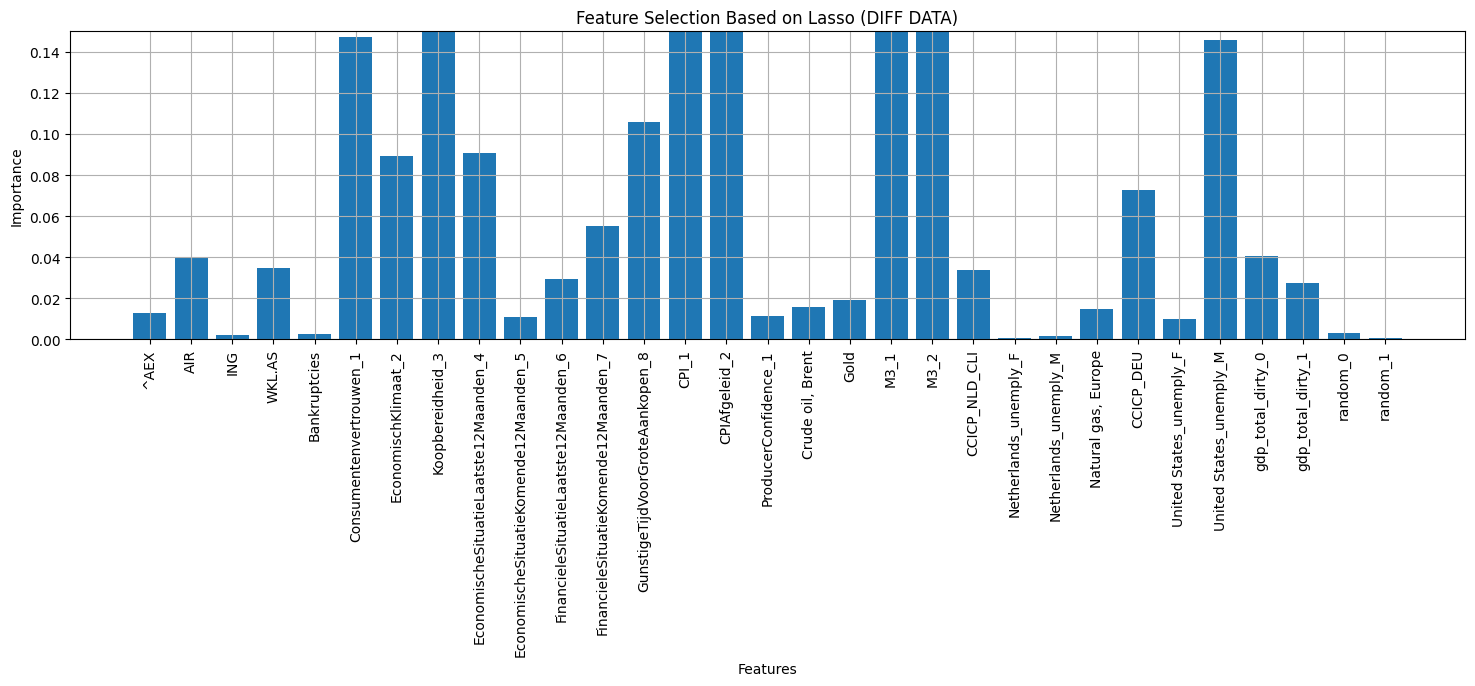

In [4734]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [4735]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])
df_lag

,gdp_total,gdp_total_lag_1,^AEX_lag_1,AIR_lag_1,ING_lag_1,WKL.AS_lag_1,Bankruptcies_lag_1,Consumentenvertrouwen_1_lag_1,EconomischKlimaat_2_lag_1,Koopbereidheid_3_lag_1,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-01,NaN,NaN,-1.777491,-1.197497,-1.448858,NaN,-0.197557,0.283872,0.403553,0.094743,...,2.294188,1.032212,-0.688984,-0.071206,0.191695,0.013769,NaN,NaN,0.253801,0.277060
1995-03-01,NaN,NaN,-1.779647,-1.192196,-1.435079,NaN,-0.453562,0.550353,0.661836,0.271144,...,2.600233,1.227644,-0.688984,-0.118037,0.179994,0.005084,NaN,NaN,0.510532,1.327262
1995-04-01,NaN,NaN,-1.825242,-1.214213,-1.420651,-0.704674,0.016480,0.728007,0.862723,0.447544,...,2.651241,1.292788,-0.690267,-0.036155,0.168293,-0.003602,NaN,NaN,0.616448,0.766779
1995-05-01,NaN,NaN,-1.797409,-1.202295,-1.380047,-0.699140,-0.348642,0.683594,0.719232,0.506344,...,2.345196,1.032212,-0.682569,0.048682,0.156592,-0.012287,NaN,NaN,-1.230267,-0.676893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,1.559078,1.592186,2.435320,2.944948,0.483039,3.512859,-0.885832,-1.004122,-0.973959,-0.846061,...,-1.327345,-0.726677,0.015229,-0.821160,-1.069961,-0.845861,1.872084,1.614069,0.076945,0.176402
2024-04-01,1.821454,1.559078,2.558293,2.865726,0.863057,3.578397,-0.906816,-0.782054,-0.801770,-0.669660,...,-1.429360,-0.856965,0.067238,-0.588237,-1.062534,-0.830772,1.170946,1.518430,0.208102,-0.389118
2024-05-01,2.405372,1.821454,2.646212,2.863475,1.096858,3.446905,-0.562679,-0.737641,-0.773072,-0.610860,...,-1.480367,-0.922109,0.135421,-0.327234,-1.055107,-0.815682,1.927128,2.082193,0.358896,-0.498498
2024-06-01,2.700880,2.405372,2.831977,3.422890,1.473182,3.660511,-0.915210,-0.782054,-0.887865,-0.552060,...,-1.531375,-0.922109,0.268600,-0.160224,-1.047680,-0.800593,2.658431,2.473191,-0.059330,-0.038337


[ 0  1  2  3  4  5  9 11 12 13 14 16 17 18 19 21 22 23 25 26 27 28 29 30
 31]
['gdp_total_lag_1', '^AEX_lag_1', 'AIR_lag_1', 'ING_lag_1', 'WKL.AS_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'CPI_1_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Gold_lag_1', 'M3_1_lag_1', 'CCICP_NLD_CLI_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'CCICP_DEU_lag_1', 'United States_unemply_F_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


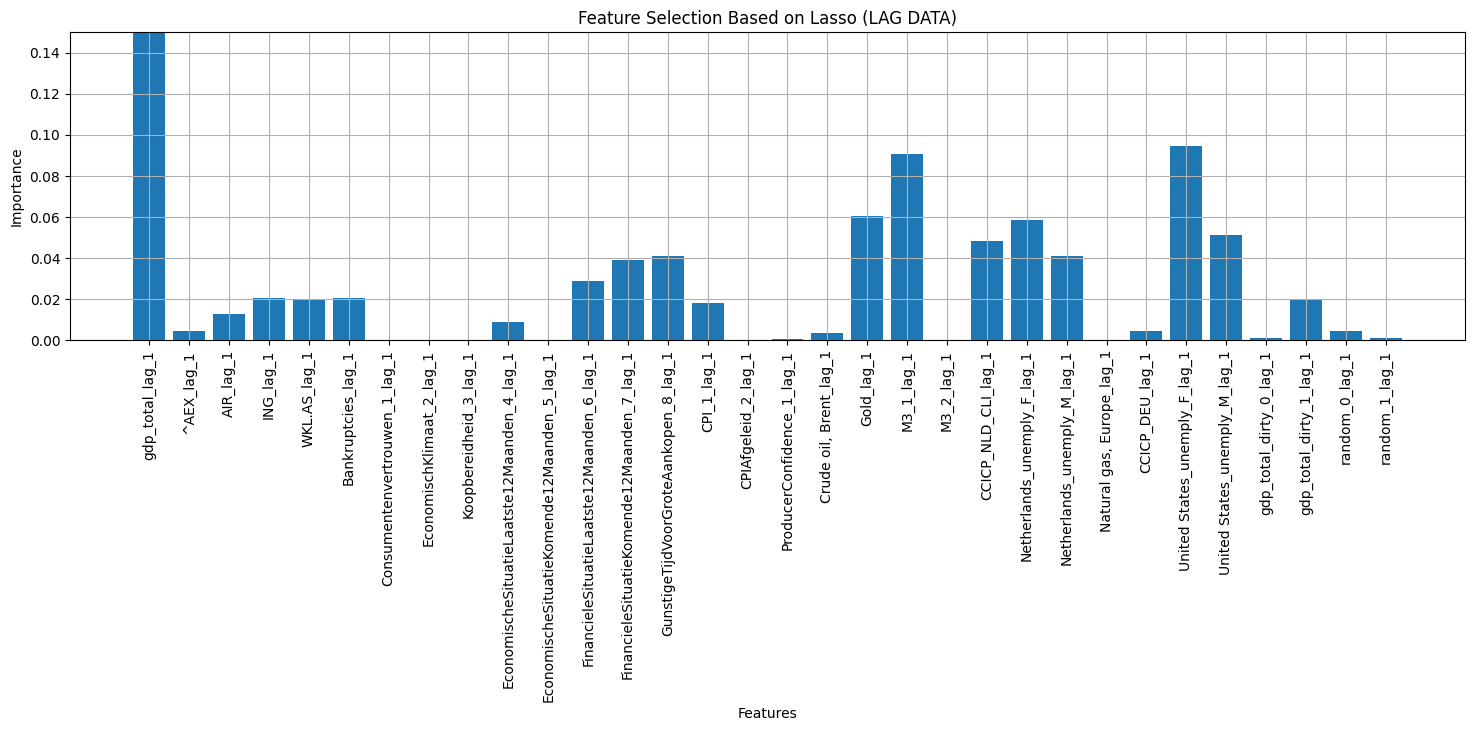

In [4736]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  2  3  4  5  7  9 11 12 13 15 16 18 20 22 23 24 25 26 28 29 30 31]
['gdp_total_lag_1', 'AIR_lag_1', 'ING_lag_1', 'WKL.AS_lag_1', 'Bankruptcies_lag_1', 'EconomischKlimaat_2_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'CPIAfgeleid_2_lag_1', 'ProducerConfidence_1_lag_1', 'Gold_lag_1', 'M3_2_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'CCICP_DEU_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


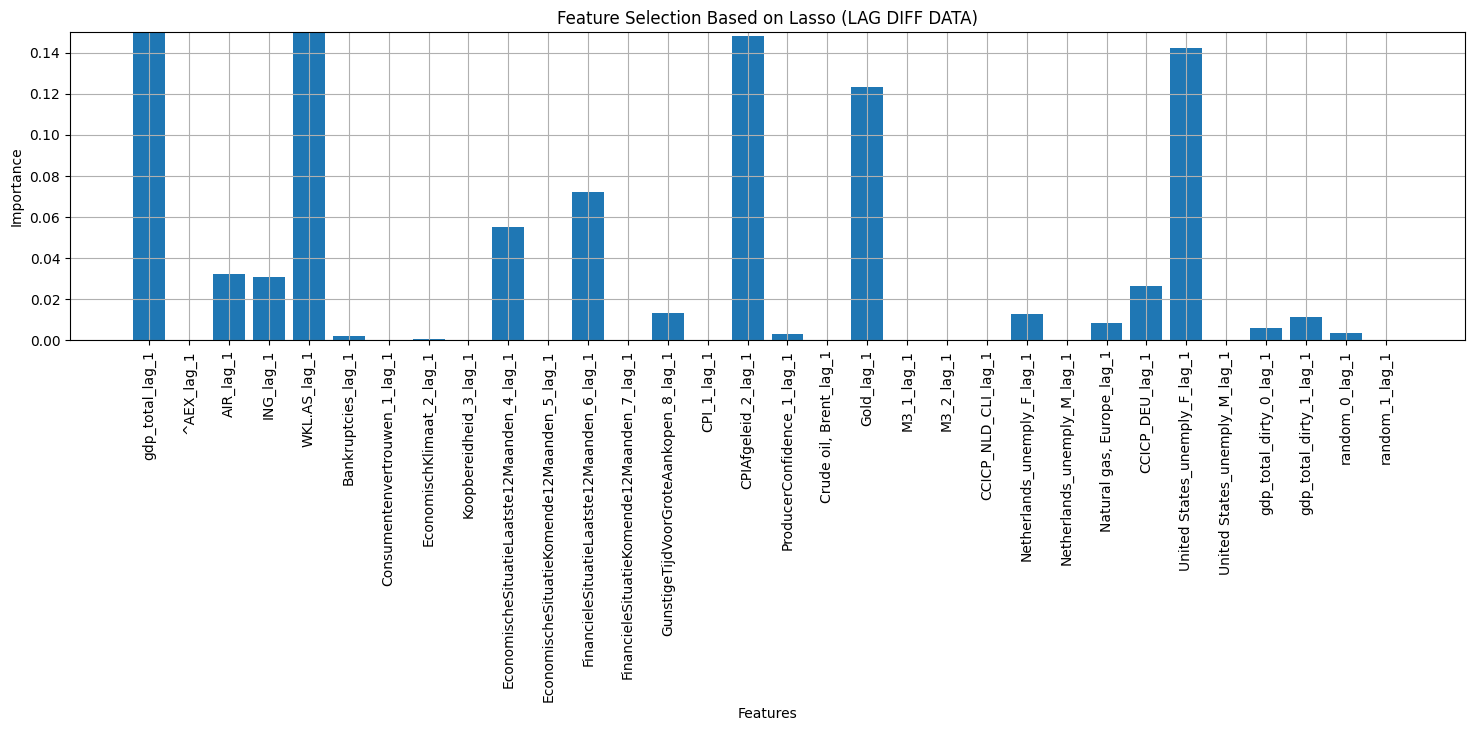

In [4737]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [4738]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(32, 3)


### If not stationary, difference, then test for stationarity again

In [4739]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]


In [4740]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
AIR,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
ING,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
WKL.AS,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischeSituatieLaatste12Maanden_4,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality


<Axes: >

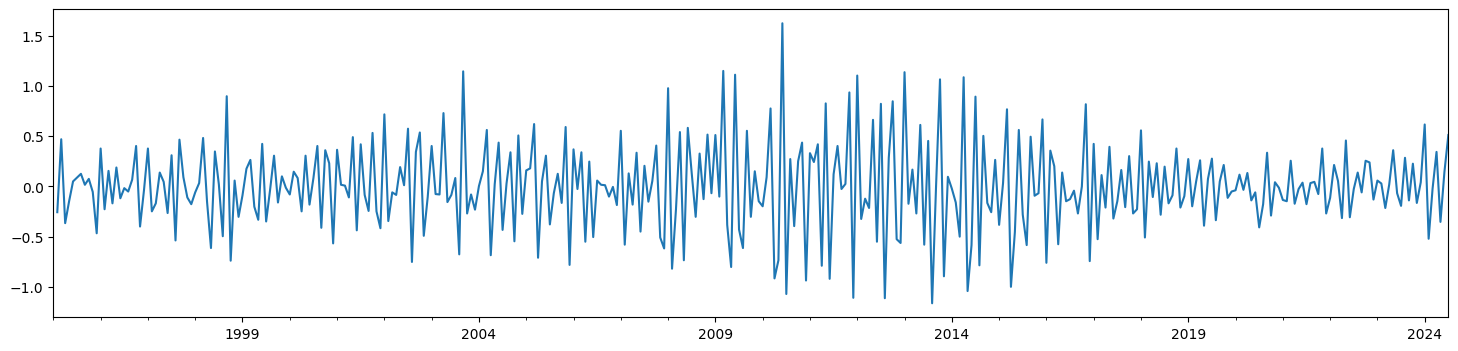

In [4741]:
scaled_features_df_diff['Bankruptcies'].plot()

[ 0  1  3  4  5  8  9 10 11 12 15 16 22 23 24 25 26 27 28 29 30]
['^AEX', 'AIR', 'WKL.AS', 'Bankruptcies', 'Consumentenvertrouwen_1', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'ProducerConfidence_1', 'Crude oil, Brent', 'Netherlands_unemply_M', 'Natural gas, Europe', 'CCICP_DEU', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


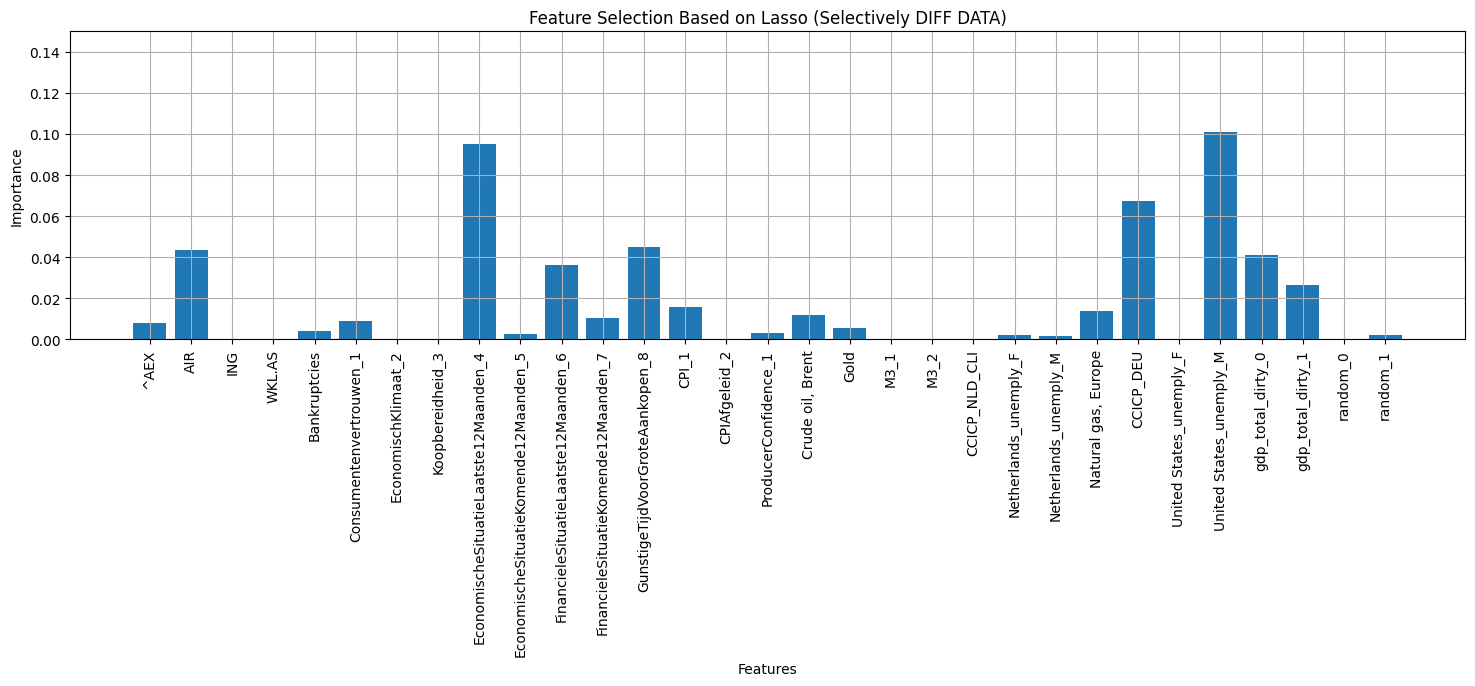

['^AEX',
 'AIR',
 'WKL.AS',
 'Bankruptcies',
 'Consumentenvertrouwen_1',
 'EconomischeSituatieLaatste12Maanden_4',
 'EconomischeSituatieKomende12Maanden_5',
 'FinancieleSituatieLaatste12Maanden_6',
 'FinancieleSituatieKomende12Maanden_7',
 'GunstigeTijdVoorGroteAankopen_8',
 'ProducerConfidence_1',
 'Crude oil, Brent',
 'Netherlands_unemply_M',
 'Natural gas, Europe',
 'CCICP_DEU',
 'United States_unemply_F',
 'United States_unemply_M',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1']

In [4742]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(355, 32)


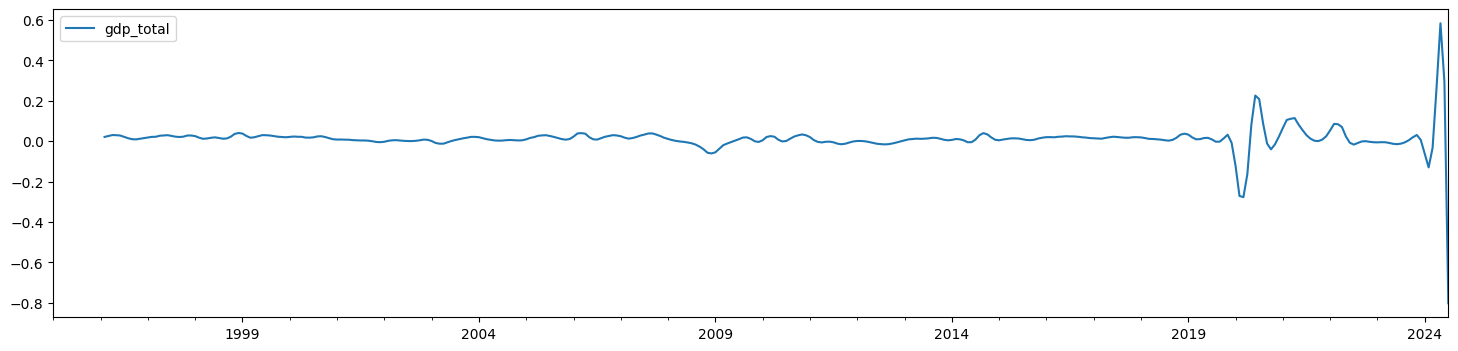

In [4743]:
scaled_features_df_diff[['gdp_total']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [4744]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(355, 64)


In [4745]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,^AEX_lag_1,AIR_lag_1,ING_lag_1,WKL.AS_lag_1,Bankruptcies_lag_1,Consumentenvertrouwen_1_lag_1,EconomischKlimaat_2_lag_1,Koopbereidheid_3_lag_1,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.032212,NaN,NaN,NaN,NaN,NaN,NaN,0.253801,0.277060
1995-03-01,NaN,NaN,-0.002156,0.005301,0.013780,NaN,-0.256005,0.266482,0.258283,0.176401,...,0.306045,1.227644,0.000000,-0.046831,-0.011701,-0.008685,NaN,NaN,0.510532,1.327262
1995-04-01,NaN,NaN,-0.045594,-0.022016,0.014427,NaN,0.470042,0.177654,0.200887,0.176401,...,0.051008,1.292788,-0.001283,0.081882,-0.011701,-0.008685,NaN,NaN,0.616448,0.766779
1995-05-01,NaN,NaN,0.027833,0.011917,0.040605,0.005533,-0.365122,-0.044414,-0.143491,0.058800,...,-0.306045,1.032212,0.007699,0.084837,-0.011701,-0.008685,NaN,NaN,-1.230267,-0.676893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,-0.033107,-0.129883,0.353628,0.383967,-0.164494,0.279013,-0.520403,0.044414,-0.057396,0.176401,...,0.000000,-0.726677,-0.181075,0.158626,-0.038528,0.011648,0.208547,-0.323498,0.076945,0.176402
2024-04-01,0.262376,-0.033107,0.122973,-0.079222,0.380018,0.065538,-0.020984,0.222068,0.172189,0.176401,...,-0.102015,-0.856965,0.052010,0.232923,0.007427,0.015089,-0.701137,-0.095639,0.208102,-0.389118
2024-05-01,0.583917,0.262376,0.087919,-0.002251,0.233801,-0.131492,0.344138,0.044414,0.028698,0.058800,...,-0.051008,-0.922109,0.068183,0.261002,0.007427,0.015089,0.756181,0.563764,0.358896,-0.498498
2024-06-01,0.295508,0.583917,0.185764,0.559416,0.376325,0.213606,-0.352531,-0.044414,-0.114793,0.058800,...,-0.051008,-0.922109,0.133179,0.167010,0.007427,0.015089,0.731303,0.390997,-0.059330,-0.038337


In [4746]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(355, 29)


[ 0  2  3  7 10 11 16 17 18 22 23 24 26]
['gdp_total_lag_1', 'AIR_lag_1', 'ING_lag_1', 'EconomischKlimaat_2_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Gold_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'United States_unemply_F_lag_1']


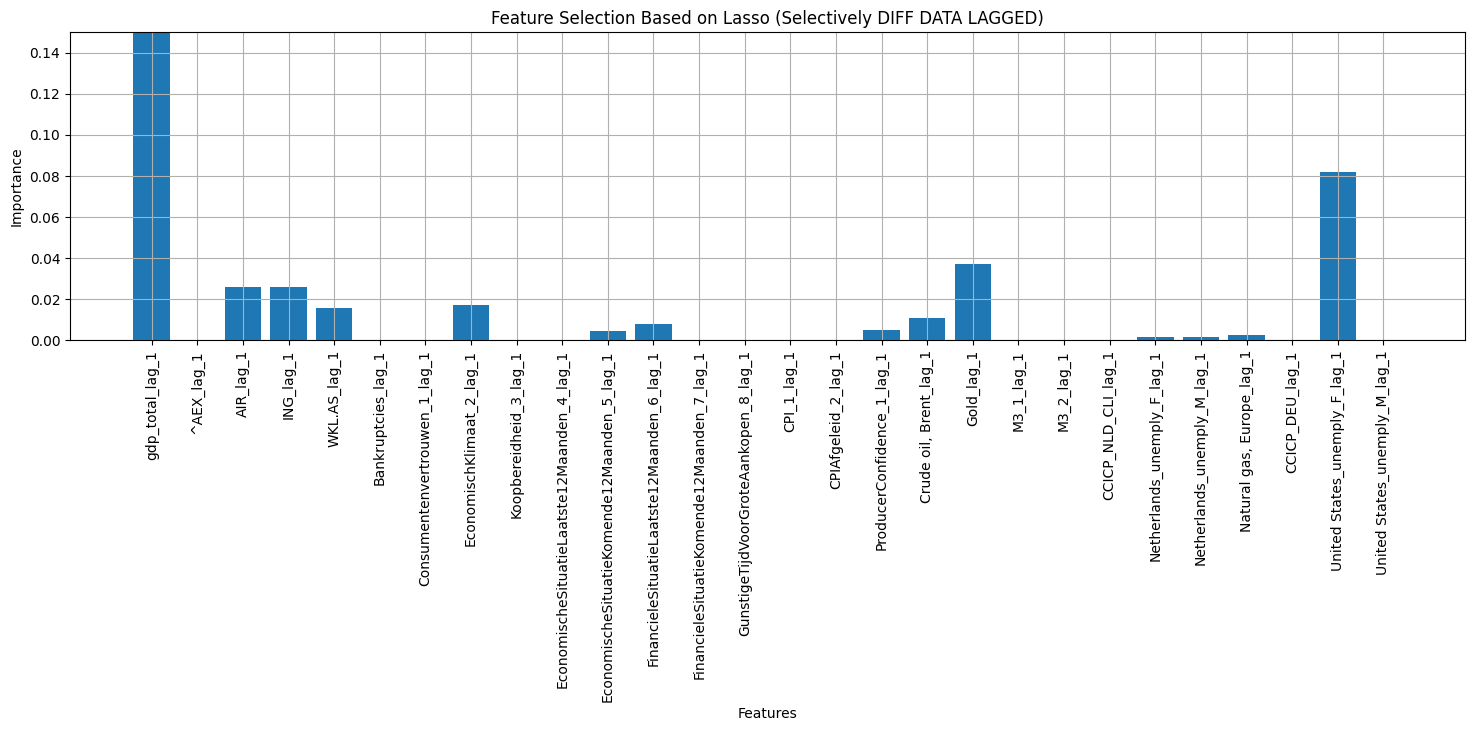

In [4747]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.0005, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [4748]:
chooseThese = ['gdp_total'] + lasout
#chooseThese.remove('United States_unemply_F_lag_1')
print(chooseThese)

['gdp_total', 'gdp_total_lag_1', 'AIR_lag_1', 'ING_lag_1', 'EconomischKlimaat_2_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Gold_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'United States_unemply_F_lag_1']


In [4749]:
scaled_features_df_diff_lag.shape
scaled_features_df_diff_lag['gdp_total'].shape


(355,)

In [4750]:
chooseThese

['gdp_total',
 'gdp_total_lag_1',
 'AIR_lag_1',
 'ING_lag_1',
 'EconomischKlimaat_2_lag_1',
 'EconomischeSituatieKomende12Maanden_5_lag_1',
 'FinancieleSituatieLaatste12Maanden_6_lag_1',
 'ProducerConfidence_1_lag_1',
 'Crude oil, Brent_lag_1',
 'Gold_lag_1',
 'Netherlands_unemply_F_lag_1',
 'Netherlands_unemply_M_lag_1',
 'Natural gas, Europe_lag_1',
 'United States_unemply_F_lag_1']

In [4751]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

##################################
test_train_split = 300
##################################


X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     64.76
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.50e-77
Time:                        10:42:26   Log-Likelihood:                 778.14
No. Observations:                 300   AIC:                            -1528.
Df Residuals:                     286   BIC:                            -1476.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

,gdp_total,^AEX,AIR,ING,WKL.AS,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,EconomischeSituatieLaatste12Maanden_4,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-01,NaN,-0.002156,0.005301,0.013780,NaN,-0.256005,0.266482,0.258283,0.176401,0.246540,...,NaN,1.032212,NaN,NaN,NaN,NaN,NaN,NaN,0.253801,0.277060
1995-03-01,NaN,-0.045594,-0.022016,0.014427,NaN,0.470042,0.177654,0.200887,0.176401,0.201715,...,0.306045,1.227644,0.000000,-0.046831,-0.011701,-0.008685,NaN,NaN,0.510532,1.327262
1995-04-01,NaN,0.027833,0.011917,0.040605,0.005533,-0.365122,-0.044414,-0.143491,0.058800,-0.067238,...,0.051008,1.292788,-0.001283,0.081882,-0.011701,-0.008685,NaN,NaN,0.616448,0.766779
1995-05-01,NaN,0.059692,0.029290,0.044108,0.009880,-0.146888,0.044414,0.057396,0.058800,0.044825,...,-0.306045,1.032212,0.007699,0.084837,-0.011701,-0.008685,NaN,NaN,-1.230267,-0.676893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,-0.033107,0.122973,-0.079222,0.380018,0.065538,-0.020984,0.222068,0.172189,0.176401,0.313778,...,0.000000,-0.726677,-0.181075,0.158626,-0.038528,0.011648,0.208547,-0.323498,0.076945,0.176402
2024-04-01,0.262376,0.087919,-0.002251,0.233801,-0.131492,0.344138,0.044414,0.028698,0.058800,0.044825,...,-0.102015,-0.856965,0.052010,0.232923,0.007427,0.015089,-0.701137,-0.095639,0.208102,-0.389118
2024-05-01,0.583917,0.185764,0.559416,0.376325,0.213606,-0.352531,-0.044414,-0.114793,0.058800,-0.067238,...,-0.051008,-0.922109,0.068183,0.261002,0.007427,0.015089,0.756181,0.563764,0.358896,-0.498498
2024-06-01,0.295508,0.103405,-0.133042,-0.069117,0.164076,0.142691,-0.044414,0.000000,-0.117600,-0.067238,...,-0.051008,-0.922109,0.133179,0.167010,0.007427,0.015089,0.731303,0.390997,-0.059330,-0.038337


<Axes: >

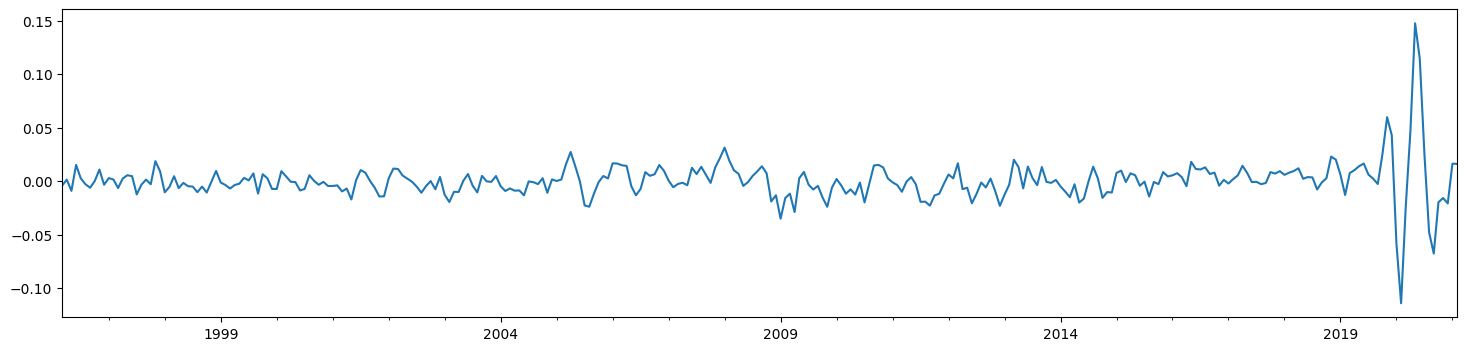

In [4752]:
results.resid.plot()

In [4753]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1
reg1.iloc[test_train_split:, 0]

2021-03-01    0.110878
2021-04-01    0.114413
2021-05-01    0.081979
2021-06-01    0.054965
2021-07-01    0.029735
2021-08-01    0.012552
2021-09-01    0.002218
2021-10-01    0.000507
2021-11-01    0.007691
2021-12-01    0.024319
2022-01-01    0.053318
2022-02-01    0.085581
2022-03-01    0.083982
2022-04-01    0.070119
2022-05-01    0.023560
2022-06-01   -0.007883
2022-07-01   -0.016858
2022-08-01   -0.008918
2022-09-01   -0.001511
2022-10-01   -0.000006
2022-11-01   -0.003051
2022-12-01   -0.005203
2023-01-01   -0.005882
2023-02-01   -0.004954
2023-03-01   -0.005283
2023-04-01   -0.008743
2023-05-01   -0.013124
2023-06-01   -0.014855
2023-07-01   -0.012145
2023-08-01   -0.005435
2023-09-01    0.005208
2023-10-01    0.019521
2023-11-01    0.030600
2023-12-01    0.006297
2024-01-01   -0.060916
2024-02-01   -0.129883
2024-03-01   -0.033107
2024-04-01    0.262376
2024-05-01    0.583917
2024-06-01    0.295508
2024-07-01   -0.802800
Name: gdp_total, dtype: float64

                real  predicted
2021-03-01  0.110878  -0.043353
2021-04-01  0.114413   0.077949
2021-05-01  0.081979  -0.191591
2021-06-01  0.054965  -0.133740
2021-07-01  0.029735  -0.055473
2021-08-01  0.012552  -0.271881
2021-09-01  0.002218  -0.252461
2021-10-01  0.000507  -0.127286
2021-11-01  0.007691   0.018935
2021-12-01  0.024319   0.168002
2022-01-01  0.053318  -0.081195
2022-02-01  0.085581   0.239277
2022-03-01  0.083982   0.017746
2022-04-01  0.070119   0.224495
2022-05-01  0.023560   0.183806
2022-06-01 -0.007883  -0.140610
2022-07-01 -0.016858  -0.140200
2022-08-01 -0.008918  -0.120954
2022-09-01 -0.001511   0.143539
2022-10-01 -0.000006  -0.375061
2022-11-01 -0.003051   0.036947
2022-12-01 -0.005203   0.207026
2023-01-01 -0.005882  -0.044907
2023-02-01 -0.004954   0.105333
2023-03-01 -0.005283   0.203374
2023-04-01 -0.008743  -0.036269
2023-05-01 -0.013124  -0.097764
2023-06-01 -0.014855  -0.146459
2023-07-01 -0.012145   0.038743
2023-08-01 -0.005435   0.069850
2023-09-

<Axes: >

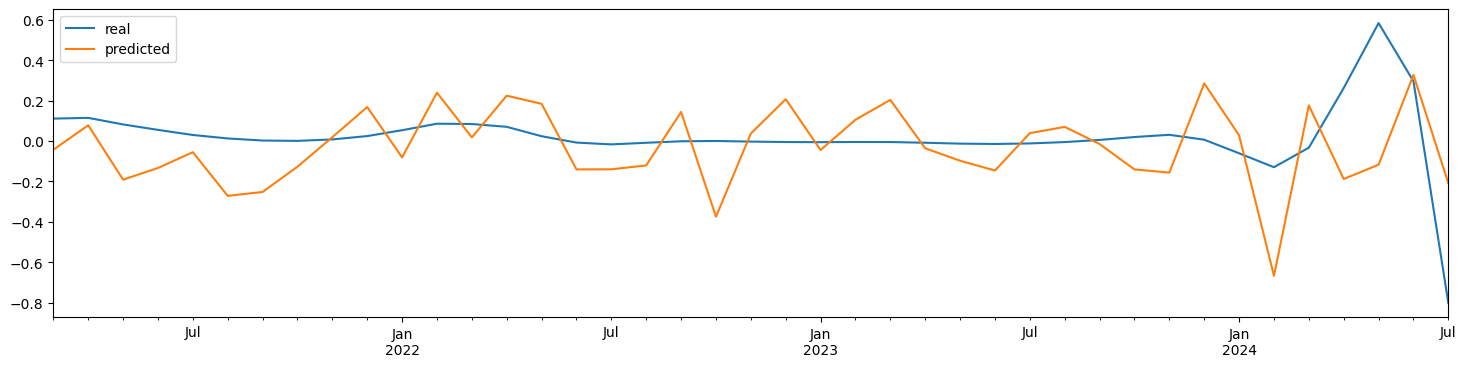

In [4754]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred})
print(df_pred)
df_pred.plot()

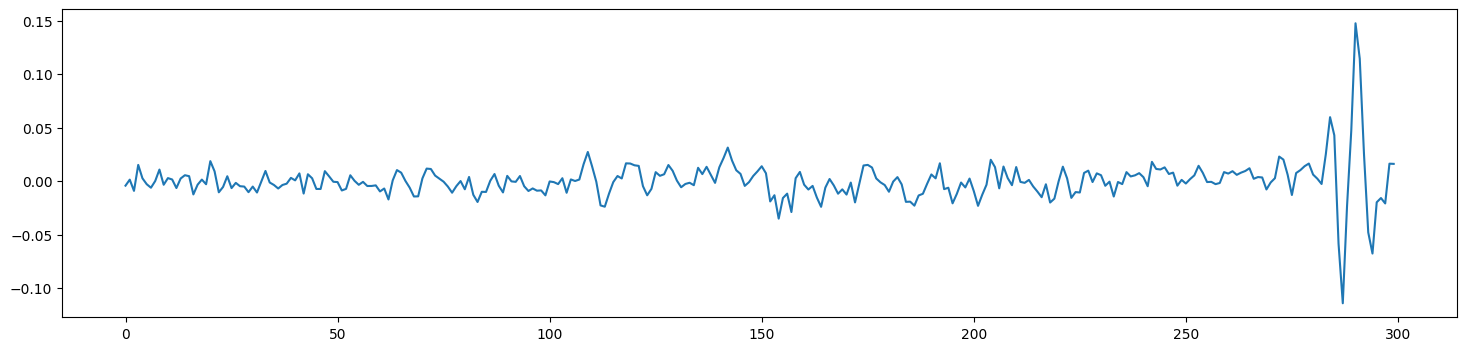

In [4755]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

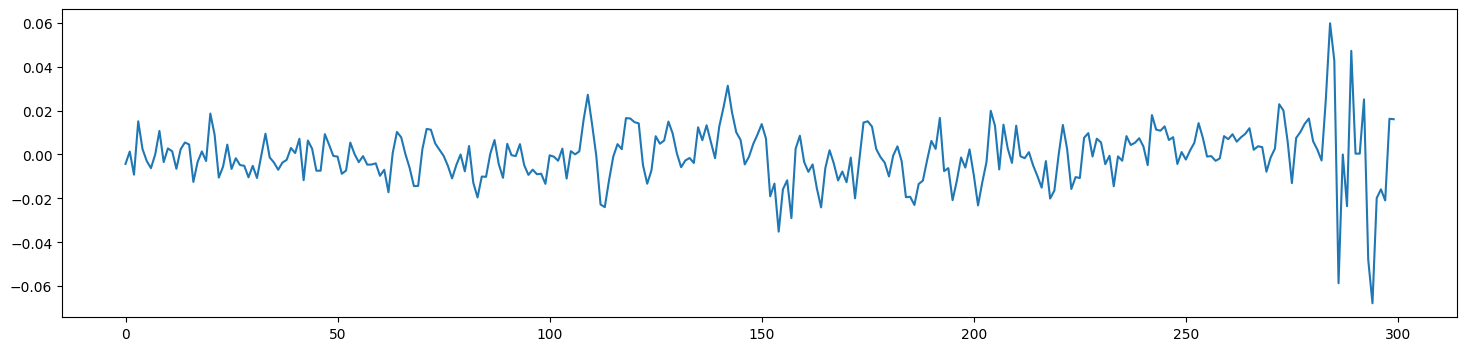

In [4756]:
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticity

In [4757]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [4758]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [4759]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.2218186776761437
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


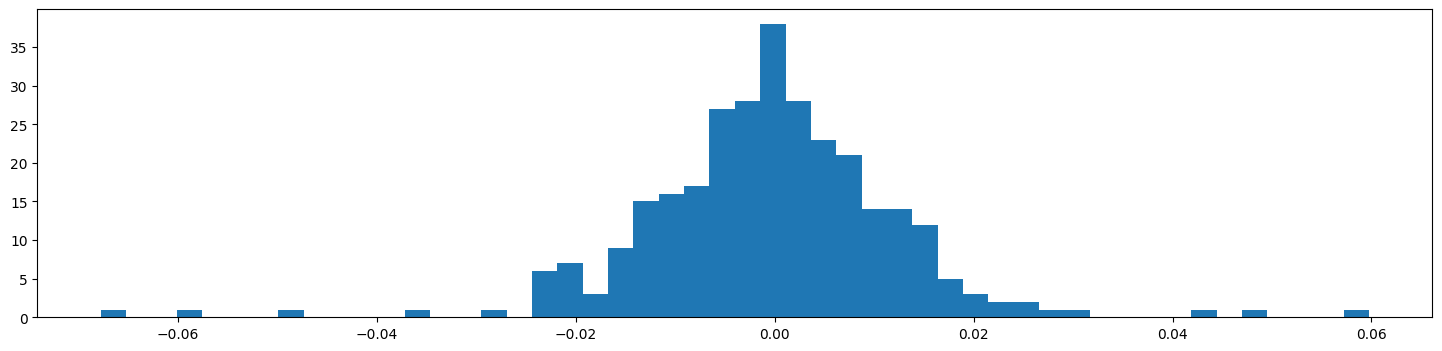

In [4760]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [4772]:
GDP_TRANSFORMATIONS.to_csv("tmp_GDP_TRANSFORMATIONS.csv ")
GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

GDP_TRANSFORMATIONS.head(20)

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
1995-01-01,NaN,NaN,NaN
1995-02-01,NaN,NaN,NaN
1995-03-01,NaN,NaN,NaN
1995-04-01,NaN,NaN,NaN
1995-05-01,NaN,NaN,NaN
1995-06-01,NaN,NaN,NaN
1995-07-01,NaN,NaN,NaN
1995-08-01,NaN,NaN,NaN
1995-09-01,NaN,NaN,NaN
1995-10-01,NaN,NaN,NaN


In [ ]:
def diff_inv_Transformation(df_diff, first_value):
    series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
    return series_inverted

recon1 = diff_inv_Transformation(y_true, GDP_TRANSFORMATIONS.loc['2/1/1996', 'gdp_total_scaled'])

In [ ]:
def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
    return data * std + mean

std_inv_Transformation(recon1)


array([136251.11753482, 136897.44894913, 137669.        , 138421.88966665,
       139129.0743962 , 139671.        , 140037.78176012, 140285.30151569,
       140513.        , 140821.9177909 , 141202.56435882, 141673.        ,
       142216.04996566, 142769.69724154, 143455.        , 144180.95961919,
       144934.37620696, 145595.        , 146162.39475538, 146687.96813824,
       147256.        , 147966.4508241 , 148682.12588926, 149317.        ,
       149754.45484242, 150051.08792508, 150392.        , 150819.13719658,
       151299.57130835, 151706.        , 152015.03133146, 152358.94978945,
       152911.        , 153822.2502654 , 154852.71446927, 155808.        ,
       156463.25108227, 156897.56335954, 157390.        , 158016.95720623,
       158775.21603064, 159525.        , 160238.75929944, 160880.70611348,
       161440.        , 161966.471847  , 162460.13940623, 162995.        ,
       163580.01059984, 164136.18144322, 164685.        , 165138.49383421,
       165582.79000961, 1